# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn import set_config
from imblearn.pipeline import Pipeline as imbPipeline ,make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler , OrdinalEncoder
from feature_engine.selection import DropFeatures
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import make_scorer , precision_score , recall_score , accuracy_score
from scipy.stats import chi2_contingency
from sklearn.model_selection import cross_val_predict
%matplotlib inline

# Loading data and exploring 

In [2]:
Titanic_dataset=pd.read_csv(r"C:\Users\Administrator\Desktop\my_lab\Titanic\train.csv")

In [3]:
Titanic_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
Titanic_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
Titanic_dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [6]:
Titanic_dataset.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
# What percentage survived and unsurvived
percentage = Titanic_dataset["Survived"].value_counts(normalize=True) * 100
percentage

0    61.616162
1    38.383838
Name: Survived, dtype: float64

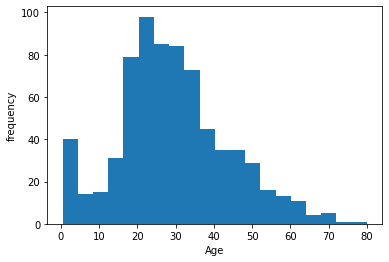

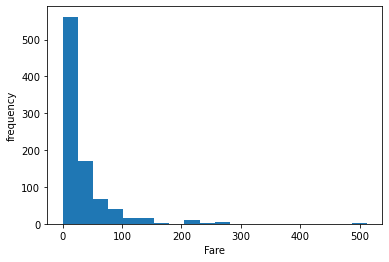

In [8]:
numerical_var=["Age" , 'Fare']
for col in numerical_var:
    plt.hist(data=Titanic_dataset , x=col, bins=20)
    plt.xlabel(col)
    plt.ylabel('frequency')
    plt.show()

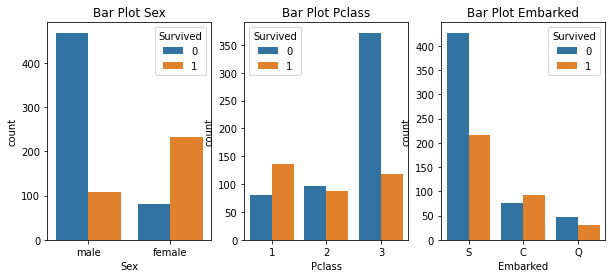

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 4))
sns.countplot(x="Sex" , hue='Survived' , data=Titanic_dataset, ax=axes[0])
axes[0].set_title('Bar Plot Sex')
sns.countplot(x="Pclass" , hue='Survived' , data=Titanic_dataset, ax=axes[1])
axes[1].set_title('Bar Plot Pclass')
sns.countplot(x="Embarked" , hue='Survived' , data=Titanic_dataset , ax=axes[2])
axes[2].set_title('Bar Plot Embarked')
plt.show()

In [13]:
Titanic_dataset.corr().round(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.00,-0.01,-0.04,0.04,-0.06,-0.00,0.01
Survived,-0.01,1.00,-0.34,-0.08,-0.04,0.08,0.26
Pclass,-0.04,-0.34,1.00,-0.37,0.08,0.02,-0.55
Age,0.04,-0.08,-0.37,1.00,-0.31,-0.19,0.10
SibSp,-0.06,-0.04,0.08,-0.31,1.00,0.41,0.16
Parch,-0.00,0.08,0.02,-0.19,0.41,1.00,0.22
Fare,0.01,0.26,-0.55,0.10,0.16,0.22,1.00


<AxesSubplot:>

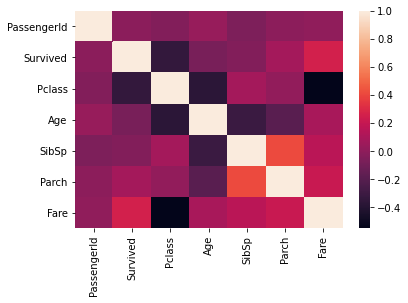

In [14]:
sns.heatmap(Titanic_dataset.corr())

## Hypothesis

In [15]:
survival_rates = Titanic_dataset.groupby('Pclass')['Survived'].mean()
chi2, p_value, _, _ = stats.chi2_contingency(Titanic_dataset.groupby(['Pclass', 'Survived']).size().unstack())
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in survival rates between passenger classes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in survival rates between passenger classes.")
print(survival_rates)


Reject the null hypothesis. There is a significant difference in survival rates between passenger classes.
Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64


In [16]:
survival_rates = Titanic_dataset.groupby('Embarked')['Survived'].mean()
chi2, p_value, _, _ = stats.chi2_contingency(Titanic_dataset.groupby(['Embarked', 'Survived']).size().unstack())
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in survival rates between Embarked classes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in survival rates between Embarked.")
print(survival_rates)


Reject the null hypothesis. There is a significant difference in survival rates between Embarked classes.
Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


In [17]:
survival_rates = Titanic_dataset.groupby('Sex')['Survived'].mean()
chi2, p_value, _, _ = stats.chi2_contingency(Titanic_dataset.groupby(['Sex', 'Survived']).size().unstack())
alpha = 0.05

if p_value < alpha:
    print("Reject the null hypothesis. There is a significant difference in survival rates between Sex classes.")
else:
    print("Fail to reject the null hypothesis. There is no significant difference in survival rates between Sex.")
print(survival_rates)

Reject the null hypothesis. There is a significant difference in survival rates between Sex classes.
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


## DataPreprocessing

## Adding New Feature

In [18]:
class FamilySizeFeature(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        dataset = X.copy()
        dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
        bins = [1, 2, 3, 4, 5, 6, 7, 9, 11, 12]
        labels = ['Alone', 'Small', 'Small', 'Small', 'Small', 'Small', 'Large', 'Large', 'Large']
        dataset['FamilySizeCategory'] = pd.cut(dataset['FamilySize'], bins=bins, labels=labels, right=False, ordered=False)
        return dataset.drop(['SibSp', 'Parch', 'FamilySize'], axis=1)


In [19]:
Titanic_dataset['Fare_log'] = np.log1p(Titanic_dataset["Fare"])

# Training

## split_train_test

In [20]:
y=Titanic_dataset["Survived"]
X=Titanic_dataset.drop('Survived' , axis=1)

In [21]:
X_train, X_test , y_train , y_test=train_test_split(X , y , test_size=0.2 , random_state=42, stratify = y)

In [22]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Fare_log
692,693,3,"Lam, Mr. Ali",male,NaN,0,0,1601,56.4958,NaN,S,4.051712
481,482,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S,0.000000
527,528,1,"Farthing, Mr. John",male,NaN,0,0,PC 17483,221.7792,C95,S,5.406181
855,856,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S,2.336987
801,802,2,"Collyer, Mrs. Harvey (Charlotte Annie Tate)",female,31.0,1,1,C.A. 31921,26.2500,NaN,S,3.305054


## Pipeline & Model Selection

In [23]:
list_drop=list(X_train[['PassengerId' , 'Name' , 'Cabin' , 'Ticket' , 'Fare']])
list_cat=list(X_train[["Sex" , "Embarked" , 'Pclass']])
list_num=list(X_train[["Age" , "Fare_log" ]])


In [24]:
# Linear model 
lr = LogisticRegression(warm_start=True, max_iter=400)
# RandomForest
rf = RandomForestClassifier()
# XGB
xgb = XGBClassifier(tree_method="hist", verbosity=0, silent=True)
# Ensemble
lr_xgb_rf = VotingClassifier(estimators=[('lr', lr), ('xgb', xgb), ('rf', rf)], voting='soft')

In [25]:
ppl=imbPipeline([
    ('familysize' , FamilySizeFeature() ),
    ('drop_col' , DropFeatures(list_drop)),
    ('cleaning' , ColumnTransformer([
  
        
        ('number' , make_pipeline(SimpleImputer(strategy="mean") , MinMaxScaler()) ,list_num ), 
        ('category' , make_pipeline(SimpleImputer(strategy='most_frequent') ,OneHotEncoder(handle_unknown='ignore')), list_cat), 
        ('category0' , make_pipeline(OrdinalEncoder()), ["FamilySizeCategory"]), 
         ])),
    ('smote' , SMOTE()),
    ('ensemble' , lr_xgb_rf),
    
    ])

In [26]:
set_config(display="diagram")
ppl.fit(X_train, y_train)

Pipeline(steps=[('familysize', FamilySizeFeature()),
                ('drop_col',
                 DropFeatures(features_to_drop=['PassengerId', 'Name', 'Cabin',
                                                'Ticket', 'Fare'])),
                ('cleaning',
                 ColumnTransformer(transformers=[('number',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare_log']),
                                                 ('category',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   Simpl...
                                                             interaction_constraints=None,
                                                             learning_rate=None,
                                                             max_bin=None,
                                                             max_cat_threshold=None,
                                                             max_cat_to_onehot=None,
                                                             max_delta_step=None,
                                                             max_depth=None,
                                                             max_leaves=None,
                                                             min_child_weight=None,
                                                             missing=nan,
                                                             monotone_constraints=None,
                                                             n_estimators=100,
                                                             n_jobs=None,
                                                             num_parallel_tree=None,
                                                             predictor=None,
                                                             random_state=None, ...)),
                                              ('rf', RandomForestClassifier())],
                                  voting='soft'))])

In [28]:
y_pred = cross_val_predict(ppl , X_train, y_train , cv=3) 
print('Accuracy' , round ( accuracy_score(y_train, y_pred) , 2))
print('Precision:',round( precision_score(y_train, y_pred) , 2))
print('Recall:', round (recall_score(y_train, y_pred) , 2))

Accuracy 0.8
Precision: 0.75
Recall: 0.74
